In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys

import pycomlink as pycml

In [3]:
import sys
sys.path.append('..')

import ragali as rgl

## Load radar, CML and gauge data

In [4]:
ds_radar = xr.open_dataset('data/openMRG_example_rad.nc')
ds_radar.coords['lon'] = ds_radar.lon
ds_radar.coords['lat'] = ds_radar.lat

ds_cmls = xr.open_dataset('data/openMRG_example.nc')

ds_city_gauges = xr.open_dataset('data/openMRG_city_gauges_20150827.nc')

## Do basic CML processing

Note that this is just a default processing which was not adjusted to the dataset.

In [5]:
# calculate total loss
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl
# seperate periods of rain from dry time steps
ds_cmls["wet"] = ds_cmls.tl.rolling(time=60, center=True).std(skipna=False) > 0.8
# estiamte the baseline during rain events
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)


ds_cmls['A'] = ds_cmls.tl - ds_cmls.baseline
ds_cmls['A'] = ds_cmls.A.where(ds_cmls.A >= 0, 0)

ds_cmls['waa'] = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
    A_obs=ds_cmls.A,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization,
    L_km=ds_cmls.length / 1e3,
    gamma=(2.06e-05)/1.4, # some values, maybe from Graf et al 2020...
    l_antenna=0.0043, 
    delta=0.24*1.5,
)

# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A_rain"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A_rain"].values[ds_cmls.A_rain < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A_rain,
    L_km=ds_cmls.length.astype(float)/1000, # convert to km
    f_GHz=ds_cmls.frequency/1000, # convert to GHz
    pol=ds_cmls.polarization,
)

# Remove some very short CMLs (< 1 km) with frequency below 30 GHz
ds_cmls_sel = ds_cmls.where(~((ds_cmls.length/1000 < 2) & (ds_cmls.frequency/1000 < 30)), drop=True)
ds_cmls_sel = ds_cmls_sel.where(ds_cmls.length/1000 > 1, drop=True).isel(sublink_id=0)


## Aggregate to 1h and plot selected hour on map

In [6]:
ds_radar_1h = ds_radar.resample(time='H', label='right').mean()
# TODO: Does the city gauge data have a temporal shift??????????
ds_city_gauges_1h = ds_city_gauges.resample(time='H', label='right').sum()
ds_cmls_1h = ds_cmls_sel.R.resample(time='H', label='right').mean()

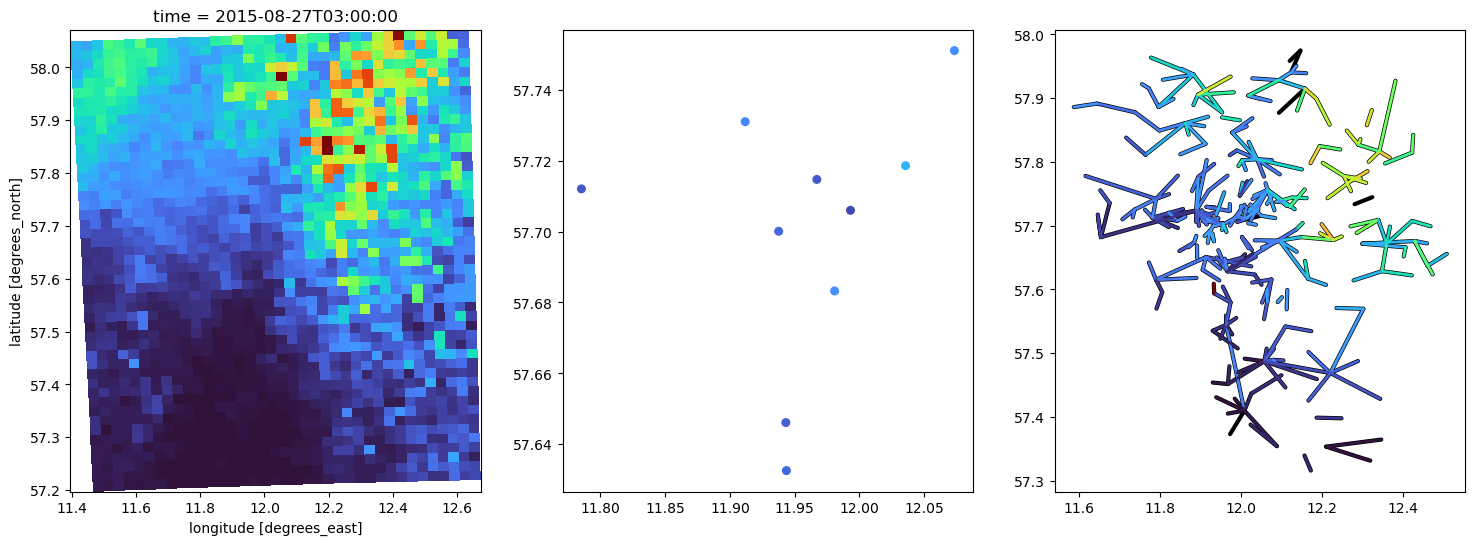

In [7]:
t = '2015-08-27T03:00:00'
vmin = 0
vmax = 10
cmap = 'turbo'

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
ds_radar_1h.sel(time=t).rainfall.plot(
    x='lon', y='lat', cmap=cmap, vmin=vmin, vmax=vmax, ax=axs[0], add_colorbar=False)
axs[1].scatter(
    ds_city_gauges.lon, 
    ds_city_gauges.lat, 
    c=ds_city_gauges_1h.sel(time=t).rainfall_amount,
    cmap='turbo', 
    vmin=vmin, 
    vmax=vmax, 
    s=30,
)
rgl.plot_map.scatter_line(
    ds_cmls_1h.sel(time=t),
    vmin=vmin,
    vmax=vmax,
    cmap='turbo',
    ax=axs[2]);

## Preliminary code to get grid values at lines and point

In [8]:
# TODO!!!!!!!!!!!: Do not use lon-lat but x-y or, at least, make both possible but x-y the default

# TODO: Use `poligrain` functions instead of this mess here...


def get_grid_at_line(da_gridded_data, ds_line_data, grid_point_location='center'):
    """ Get values of gridded data at the intersections with lines."""
    # TODO: Also allow something like `nnear` and `stat` kwarg as is done in 
    #       wradlib for point data.

    # TODO: Cache the intersection weights because it can be slow to calculate them.
    #       Or do the approach of wradlib of the RawAtObs class which does the slow initial 
    #       calculations of neighbors in the __init__ which is then reused in __call__()
    intersect_weights = rgl.grid_intersection.calc_sparse_intersect_weights_for_several_cmls(
        ds_cmls=ds_line_data,
        x_grid=da_gridded_data.lon.values,
        y_grid=da_gridded_data.lat.values,
        #grid_point_location='lower_left',
        grid_point_location=grid_point_location,
    )

    # Use grid intersection weights to calculate radar-CML path-averages
    gridded_data_along_line = rgl.grid_intersection.get_grid_time_series_at_intersections(
        #grid_data=ds_radar.rainfall.transpose('time', 'x', 'y').values, # only needed if we have to transpose in the function above
        grid_data=da_gridded_data.values,
        intersect_weights=intersect_weights,
    )

    # TODO: Add these coordinates already in the function to get the time series
    gridded_data_along_line['time'] = da_gridded_data.time
    gridded_data_along_line['site_0_lon'] = intersect_weights.site_0_lon
    gridded_data_along_line['site_1_lat'] = intersect_weights.site_1_lat
    gridded_data_along_line['site_1_lon'] = intersect_weights.site_1_lon
    gridded_data_along_line['site_0_lat'] = intersect_weights.site_0_lat

    return gridded_data_along_line

def get_grid_at_point(da_gridded_data, da_point_data, grid_point_location='center', nnear=9, stat="best"):
    """ Get values of gridded data at locations of points. """
    # TODO: account for `grid_point_location` which is not yet done here.

    # TODO: Copy-paste the relevant stuff from wradlib and add to own code
    import wradlib

    # Get radar pixel coordinates as (N, 2) array
    #x_grid, y_grid = np.meshgrid(da_gridded_data.lon, da_gridded_data.lat)
    x_grid, y_grid = da_gridded_data.lon.values, da_gridded_data.lat.values
    xy_grid = np.array(list(zip(x_grid.flatten(), y_grid.flatten())))

    # Initialize function to get grid values at points
    xy_points = np.stack([da_point_data.lon, da_point_data.lat], axis=1)
    raw_at_obs_adjuster = wradlib.adjust.RawAtObs(
        obs_coords=xy_points, #df_stations.loc[:, ["x", "y"]].values,
        raw_coords=xy_grid,
        nnear=nnear,
        stat=stat,
    )

    gridded_data_at_point_list = []
    for t in da_gridded_data.time.values:
        da_gridded_data_t = da_gridded_data.sel(time=t)
        da_point_data_t = da_point_data.sel(time=t)
        
        gridded_data_at_point_list.append(
            raw_at_obs_adjuster(
                obs=da_point_data_t.values, #df_stations.loc[:, "rainfall_amount"].values,
                raw=da_gridded_data_t.values.flatten(),
            )
        )

    return xr.DataArray(
        data=gridded_data_at_point_list,
        dims=da_point_data.dims,
        coords={
            'time': da_gridded_data.time,
            'lon':  da_point_data.lon,
            'lat': da_point_data.lat,
        }
    )
    
    

## Get radar data at points and at CMLs

In [9]:
radar_along_cml = get_grid_at_line(ds_radar_1h.rainfall, ds_cmls)
radar_at_points = get_grid_at_point(ds_radar_1h.rainfall, da_point_data=ds_city_gauges_1h.rainfall_amount)

## Plot radar data at point and CMLs, as well as diff to point and CML observaions

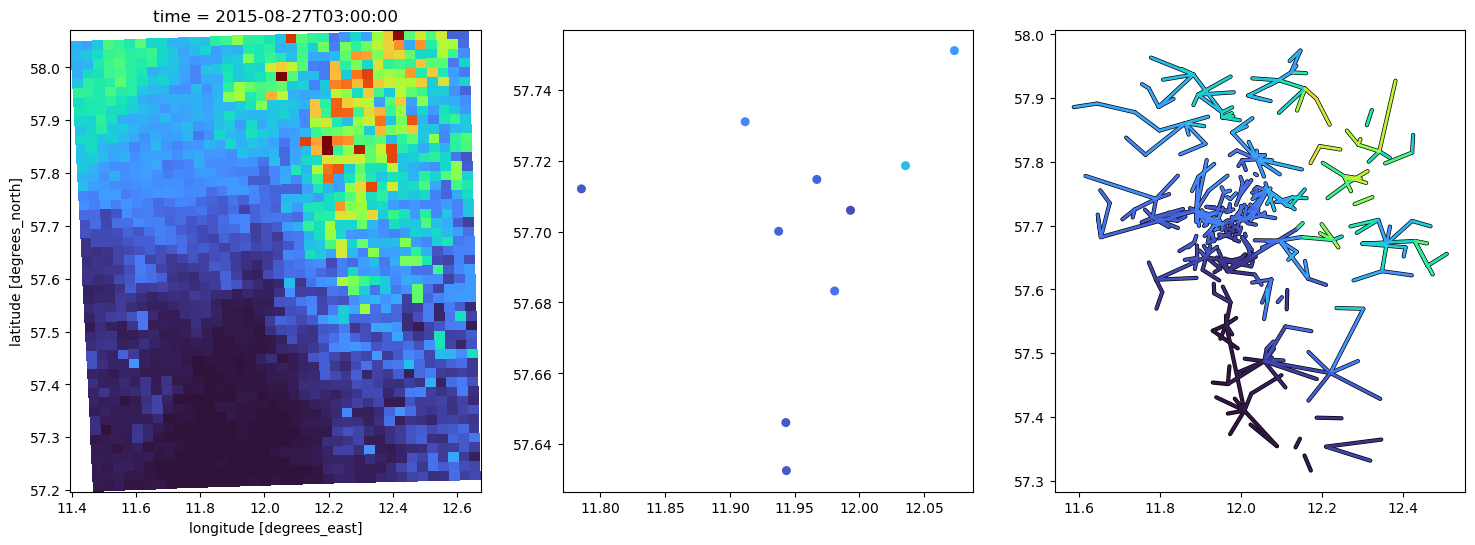

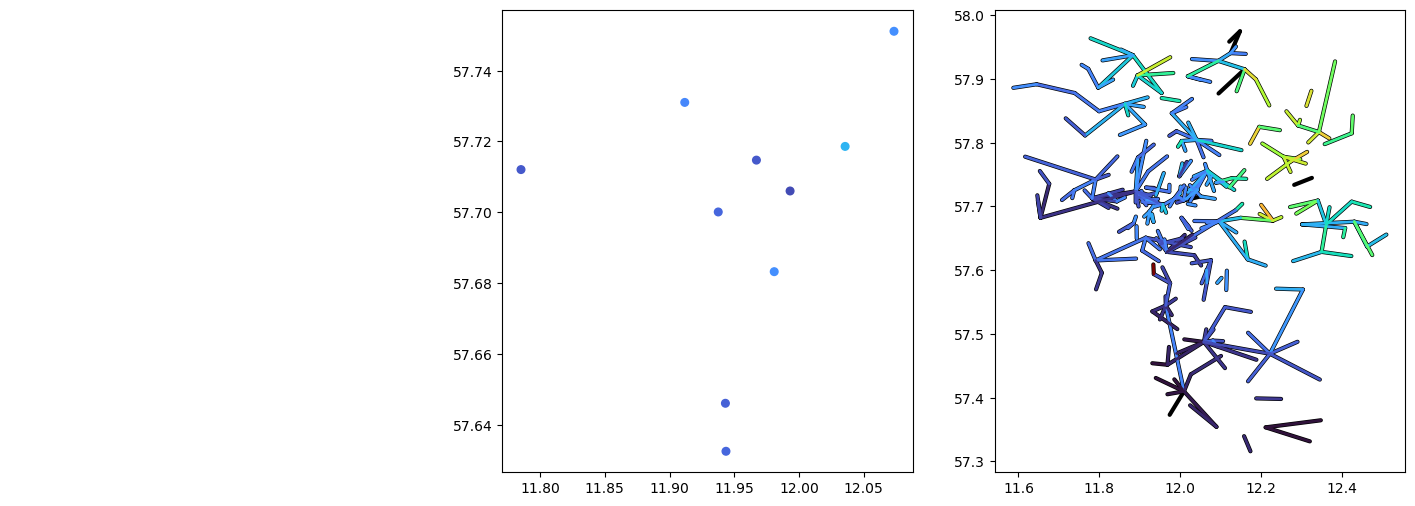

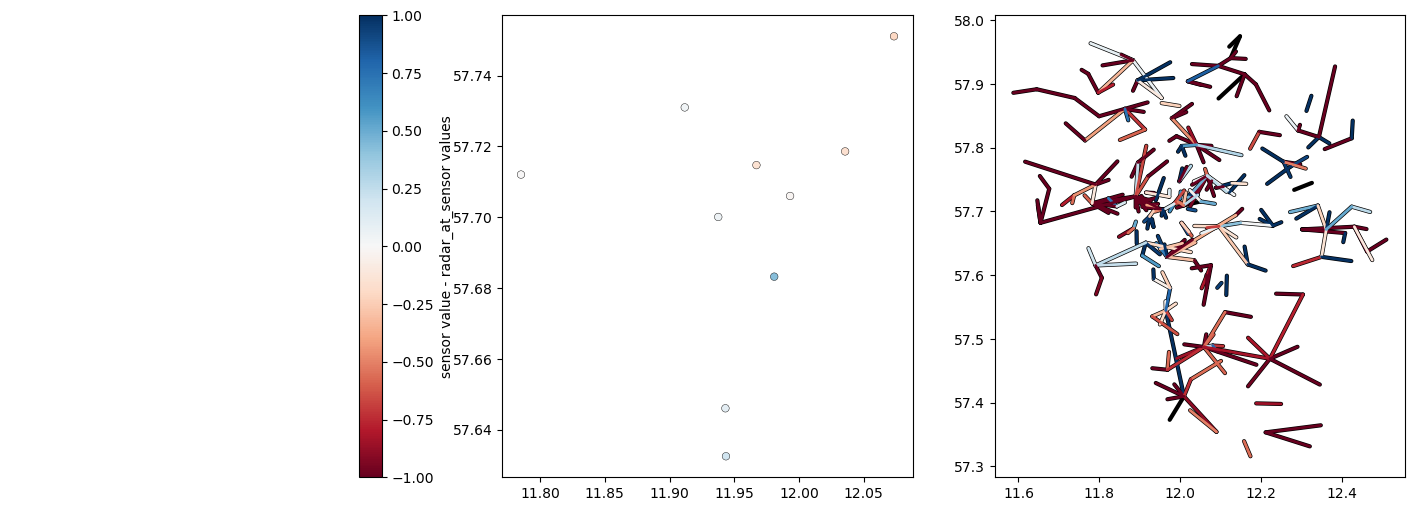

In [10]:
t = '2015-08-27T03:00:00'
vmin = 0
vmax = 10
cmap = 'turbo'

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
ds_radar_1h.sel(time=t).rainfall.plot(
    x='lon', y='lat', cmap=cmap, vmin=vmin, vmax=vmax, ax=axs[0], add_colorbar=False)
axs[1].scatter(
    ds_city_gauges.lon, 
    ds_city_gauges.lat, 
    c=radar_at_points.sel(time=t),
    cmap='turbo', 
    vmin=vmin, 
    vmax=vmax, 
    s=30,
)
rgl.plot_map.scatter_line(
    radar_along_cml.sel(time=t),
    vmin=vmin,
    vmax=vmax,
    cmap='turbo',
    ax=axs[2]);

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].axis('off')
axs[1].scatter(
    ds_city_gauges.lon, 
    ds_city_gauges.lat, 
    c=ds_city_gauges_1h.rainfall_amount.sel(time=t),
    cmap='turbo', 
    vmin=vmin, 
    vmax=vmax, 
    s=30,
)
rgl.plot_map.scatter_line(
    ds_cmls_1h.sel(time=t),
    vmin=vmin,
    vmax=vmax,
    cmap='turbo',
    ax=axs[2]);

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].axis('off')
sc = axs[1].scatter(
    ds_city_gauges.lon, 
    ds_city_gauges.lat, 
    c=ds_city_gauges_1h.rainfall_amount.sel(time=t) - radar_at_points.sel(time=t),
    cmap='RdBu', 
    vmin=vmax/-10, 
    vmax=vmax/10, 
    s=30,
    edgecolor='k',
    linewidth=0.3,
)
rgl.plot_map.scatter_line(
    ds_cmls_1h.sel(time=t) - radar_along_cml.sel(time=t),
    vmin=vmin/-10,
    vmax=vmax/10,
    cmap='RdBu',
    ax=axs[2]);
plt.colorbar(sc, ax=axs[0], label='sensor value - radar_at_sensor values')

## Do radar adjustment

In [11]:
# TODO for simple additive adjustmenet
# - interpolate differences in space
# - add interpolate diff-field to radar field